# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)
np.random.seed(42)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split
import pNormSoftmax

# Evaluate logits

In [5]:
MODEL_ARC = 'vit_l_16_384'
DATASET = 'ImageNet'

In [6]:
logits,labels = upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                            split = 'test', device = dev, dtype=torch.get_default_dtype())
error = measures.wrong_class(logits,labels)

In [7]:
METRIC = lambda x,y: 1-metrics.AUROC(x,y)

# Optimization and RC

In [8]:
pT = pNormSoftmax.optimize.p_and_beta(logits,error,metric = METRIC)
p = pNormSoftmax.optimize.p(logits,error,metric= METRIC)
beta = pNormSoftmax.beta_heuristic(logits,p)
T = pNormSoftmax.optimize.T(logits,error,metric =  METRIC)
T_nll = pNormSoftmax.optimize.T_fromloss(logits,labels,torch.nn.CrossEntropyLoss())

In [9]:
baseline = measures.MSP(logits)
P_opt = pNormSoftmax.pNormSoftmax(logits,p,beta)
PT = pNormSoftmax.pNormSoftmax(logits,pT[0],pT[1])
TS = measures.MSP(logits.div(T))
TS_nll = measures.MSP(logits.div(T_nll))

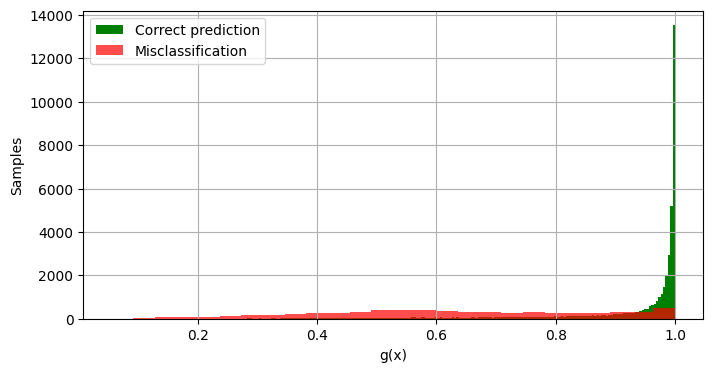

In [10]:
fig = plt.figure(figsize = (8,4))
fig.tight_layout()
plt.hist(baseline[error.logical_not()].cpu().numpy(),label = 'Correct prediction', bins= 'auto', color = 'green')
plt.hist(baseline[error].cpu().numpy(),label = 'Misclassification', bins= 'auto', alpha = 0.7, color = 'red')

plt.grid()
plt.legend()
plt.xlabel('g(x)')
plt.ylabel('Samples')
plt.savefig(os.path.join(FIGS_PATH, f'Histogram-{MODEL_ARC}.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

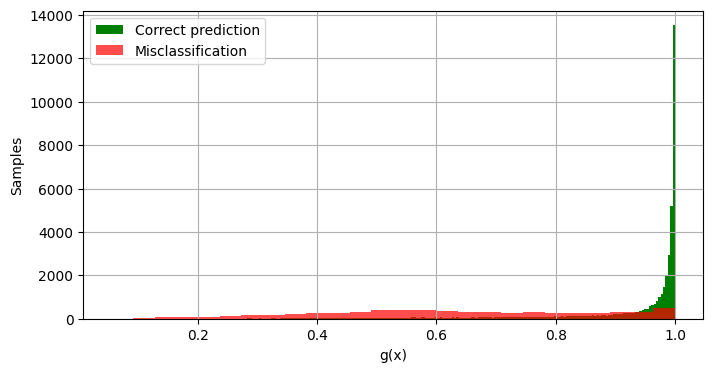

In [11]:
fig = plt.figure(figsize = (8,4))
fig.tight_layout()
plt.hist(P_opt[error.logical_not()].cpu().numpy(),label = 'Correct prediction', bins= 'auto', color = 'green')
plt.hist(P_opt[error].cpu().numpy(),label = 'Misclassification', bins= 'auto', alpha = 0.7, color = 'red')

plt.grid()
plt.legend()
plt.xlabel('g(x)')
plt.ylabel('Samples')
plt.savefig(os.path.join(FIGS_PATH, f'Histogram-{MODEL_ARC}.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()

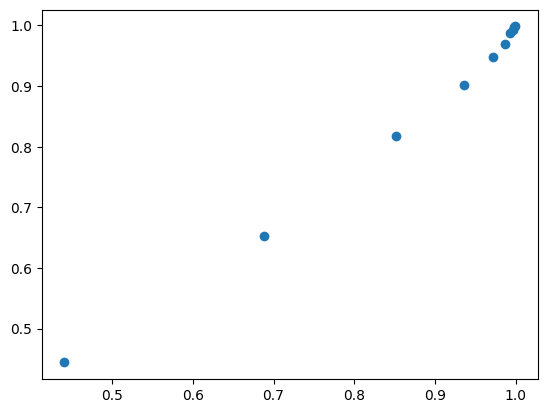

In [12]:
N_BINS = 10
AdaBin = metrics.AdaptiveECE(N_BINS)
confs,accs = AdaBin.get_bins(baseline,error)
bounds = AdaBin.get_bounds(baseline)
plt.scatter(confs.cpu(),accs.cpu())